<font color = gray size = 6>  
Industria del Cemento en Argentina
</font>  

___

<a id='contents' />

## INDICE

* [¿Cómo se comporta la serie?](#comportamiento)
    * [Descomposición de la series](#descomposicion)
* [IDENTIFICACION](#identificacion)    
    *  [¿La serie es estacionaria o no estacionaria?](#estacionaria)
        *  [Método gráfico](#grafico)
        *  [Contraste formal](#formal)
            * [ADF](#dfa)
            * [KPSS](#kpss)
        *  [Transformacion de la serie en estacionaria](#transformacion)
        
* [ESTIMACION](#estimacion)  
    * [Cálculos de los valores de p y q](#acf)
        * [AIC](#aic)
        * [BIC](#bic)
    * [Modelo](#modelo)   
* [DIAGNÓSTICO DEL MODELO](#diagnostico)    
    *  [Residuos](#residuos)
        * [No correlacionados](#incorrelacionado)
        * [Normalmente distribuidos](#distribucion_normal)
* [ESTADISTICA RESUMEN](#resumida)


* [Conclusiones](#conclusiones)

___

### Carga y transformación de los datos

In [1]:
# Preprocesamiento
import pandas as pd
import numpy as np
import unidecode
from EDA import *


# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix #matriz diagrama de dispersion con histograma en la diagonal principal
from warnings import catch_warnings
from warnings import filterwarnings

plt.style.use("seaborn")
warnings.filterwarnings("ignore")


# Modelación
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
#from statsmodels.tsa.api import VAR
from Time_series import *

# Métricas de evaluación
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error, r2_score
    
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from datetime import datetime

In [2]:
df_full = pd.read_excel("Base_cemento.xlsx",sheet_name="Datos", decimal = ",") 
df_full['Fecha'] = pd.to_datetime(df_full['Fecha'], format='%Y-%m')
df_full = df_full.set_index('Fecha')
df_full.head(2)

,Industria
Fecha,
2005-01-01,535057
2005-02-01,508744


In [3]:
df_full['mes'] = df_full.index.month
df_full['año'] = df_full.index.year
df_full.tail(5)

,Industria,mes,año
Fecha,,,
2022-12-01,932661,12,2022
2023-01-01,958230,1,2023
2023-02-01,895938,2,2023
2023-03-01,1113909,3,2023
2023-04-01,1028598,4,2023


<font color = gray size = 5>  
EDA: Análisis exploratorio de datos
</font>  

In [4]:
initial_analysis(df_full)

El DataFrame contiene 220 filas por 3 columnas.

Sus columnas tiene el nombre de:
 Index(['Industria', 'mes', 'año'], dtype='object').
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2005-01-01 to 2023-04-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Industria  220 non-null    int64
 1   mes        220 non-null    int64
 2   año        220 non-null    int64
dtypes: int64(3)
memory usage: 6.9 KB


In [5]:
medidas_descriptivas(df_full)

                                 VARIABLES CUANTITATIVAS 
                        


,count,mean,std,min,25%,50%,75%,max
Industria,220.0,892623.19,147967.00,403653.0,797504.75,897790.5,998764.25,1226632.0
mes,220.0,6.43,3.47,1.0,3.00,6.0,9.00,12.0
año,220.0,2013.67,5.31,2005.0,2009.00,2014.0,2018.00,2023.0


                                 VARIABLES CUALITATIVAS 
                        


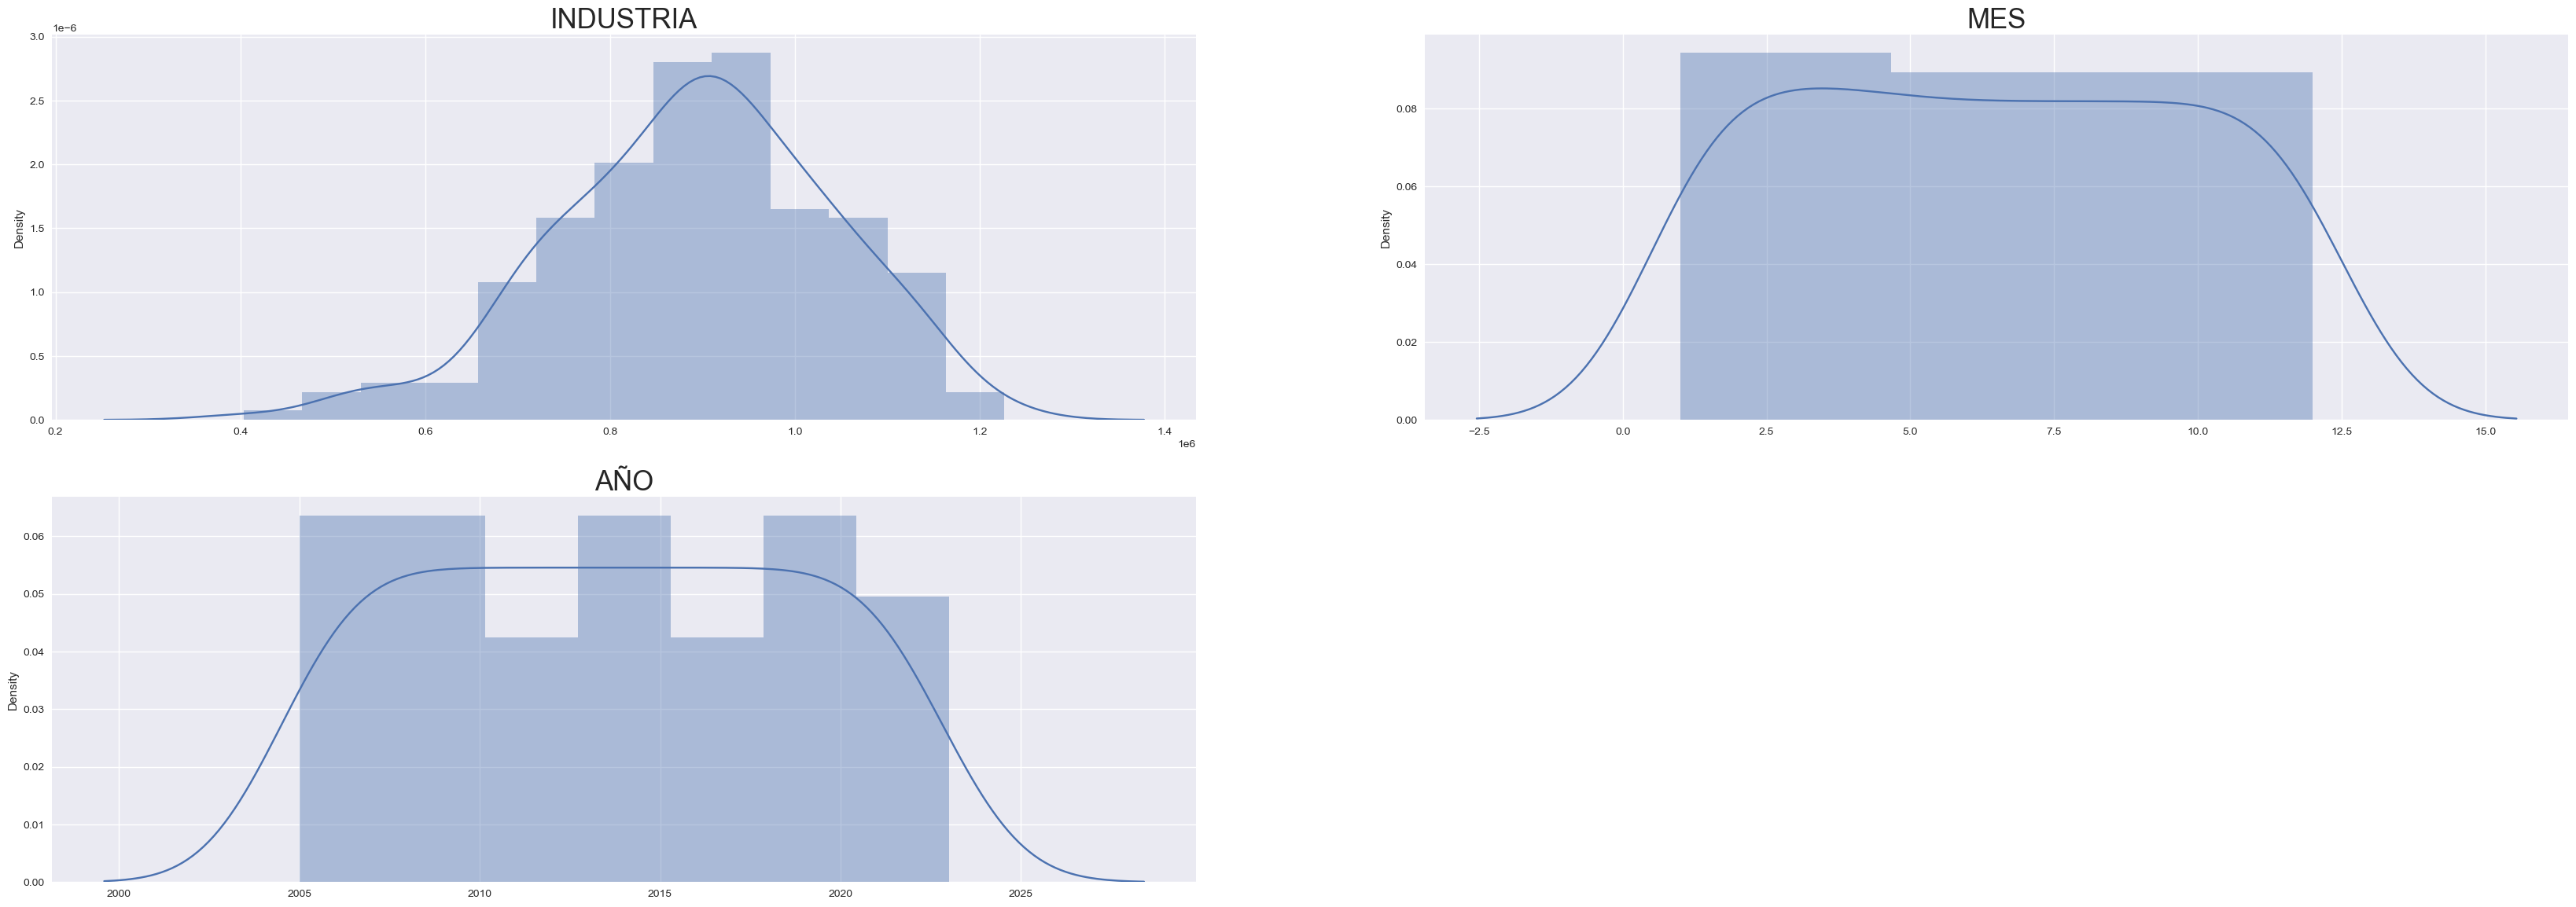

In [6]:
grafico_vbles(df_full)

### La variable que queremos utilizar

In [7]:
name = 'Industria'

In [8]:
df = df_full[['año','mes','Industria']]
df.head(2)

,año,mes,Industria
Fecha,,,
2005-01-01,2005,1,535057
2005-02-01,2005,2,508744


In [9]:
vble = df[name]
vble

Fecha
2005-01-01     535057
2005-02-01     508744
2005-03-01     553600
2005-04-01     574342
2005-05-01     580957
               ...   
2022-12-01     932661
2023-01-01     958230
2023-02-01     895938
2023-03-01    1113909
2023-04-01    1028598
Name: Industria, Length: 220, dtype: int64

Boxplot: visualiza la distribución de un conjunto de datos. Da información sobre la mediana, los cuartiles y los valores atípicos de la serie

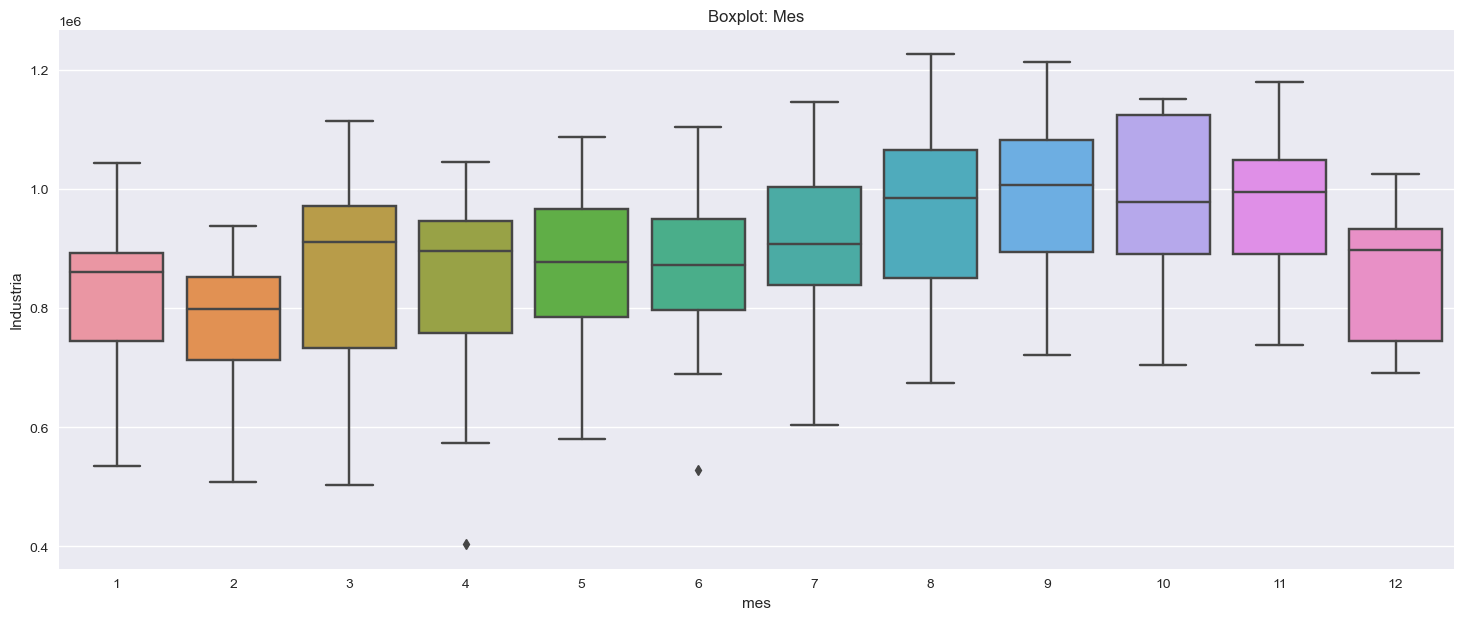

In [10]:
plt.figure(figsize=(18,7))
sns.boxplot(x ='mes', y=name, data=df)
plt.title("Boxplot: Mes")
plt.show()

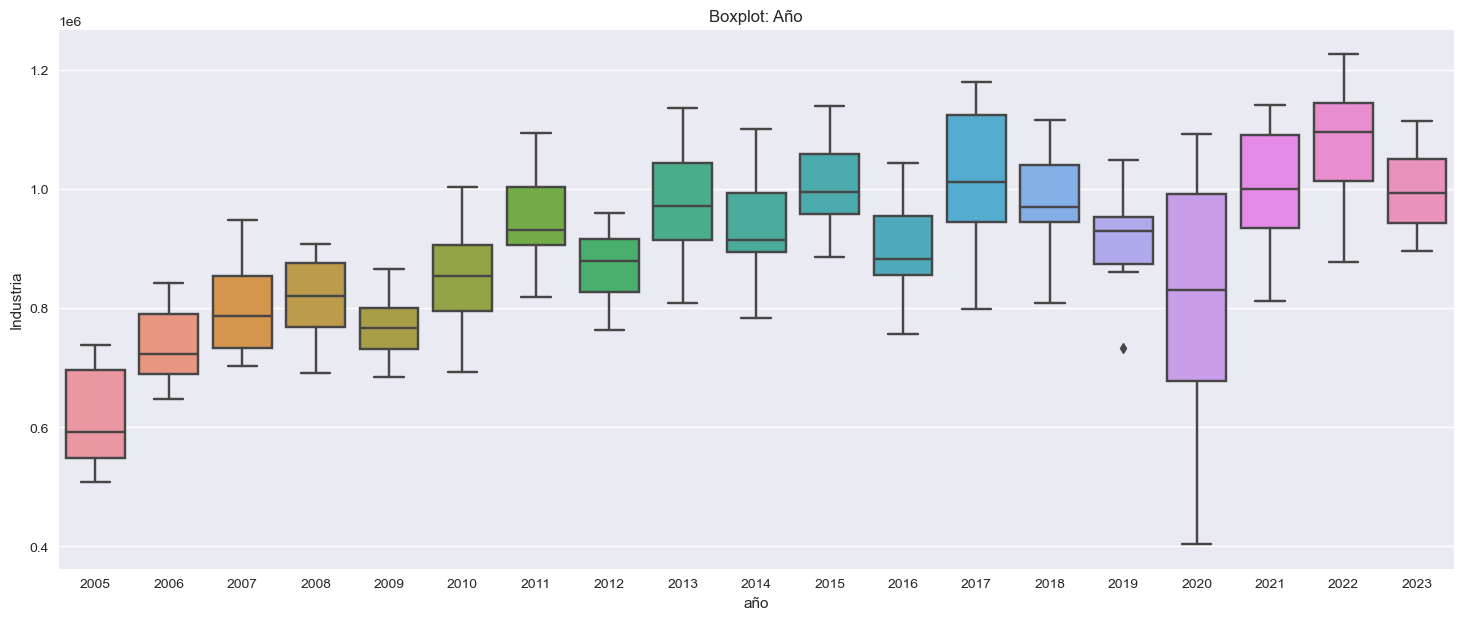

In [11]:
plt.figure(figsize=(18,7))
sns.boxplot(x ='año', y=name, data=df)
plt.title("Boxplot: Año")
plt.show()

#### Los outliers que tenemos son:

In [12]:
columna = 'mes'
lista = df[columna].unique()

outliers = outliers(lista, columna, name,df)
outliers 

La mediana de 1 es 860798.0
La mediana de 2 es 799340.0
La mediana de 3 es 911932.0
La mediana de 4 es 895697.0
La mediana de 5 es 877925.5
La mediana de 6 es 873374.5
La mediana de 7 es 907741.0
La mediana de 8 es 985560.0
La mediana de 9 es 1006501.5
La mediana de 10 es 978458.0
La mediana de 11 es 995851.0
La mediana de 12 es 898301.5


[            mes  Industria
 Fecha                     
 2020-04-01    4     403653,
             mes  Industria
 Fecha                     
 2005-06-01    6     528059]

In [13]:
valores_atipicos = outliers[0].append(outliers[1])
valores_atipicos

,mes,Industria
Fecha,,
2020-04-01,4,403653
2005-06-01,6,528059


#### Sustituimos los valores atipicos por la mediana en este caso:

In [14]:
df = df.replace({name:{528059:873374.5}})
print(df.loc['2005-06-01'])

año            2005.0
mes               6.0
Industria    873374.5
Name: 2005-06-01 00:00:00, dtype: float64


In [15]:
df = df.replace({name:{403653:895697}})
print(df.loc['2020-04-01'])

año            2020.0
mes               4.0
Industria    895697.0
Name: 2020-04-01 00:00:00, dtype: float64


Debido a la situacion de Covid tambien modificamos el mes de Marzo y Mayo del 2020

In [16]:
df = df.replace({name:{502368:911932}})
print(df.loc['2020-03-01'])

año            2020.0
mes               3.0
Industria    911932.0
Name: 2020-03-01 00:00:00, dtype: float64


In [17]:
df = df.replace({name:{648543:877925.5}})
print(df.loc['2020-05-01'])

año            2020.0
mes               5.0
Industria    877925.5
Name: 2020-05-01 00:00:00, dtype: float64


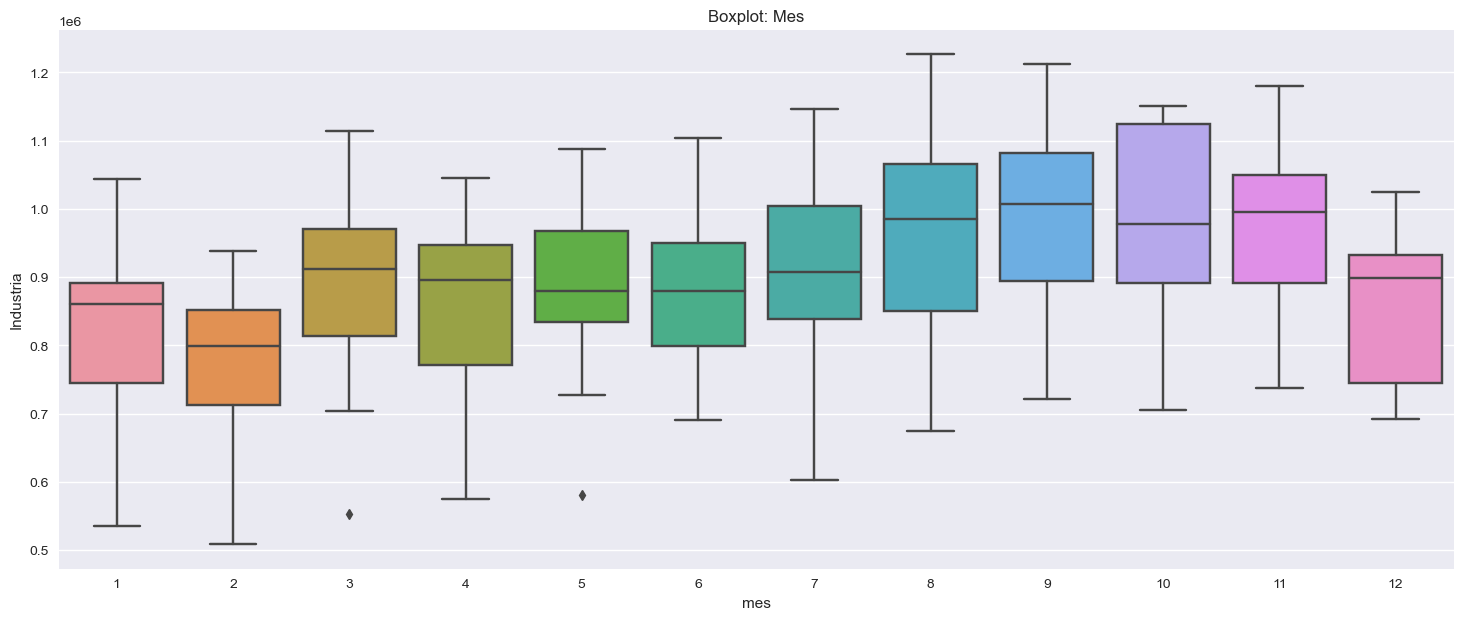

In [18]:
plt.figure(figsize=(18,7))
sns.boxplot(x ='mes', y=name, data=df)
plt.title("Boxplot: Mes")
plt.show()

> Los nuevos outliers aparecen luego de la transformacion inicial por lo que no son significamos. 

___

## ARIMA
- Unidireccional

$Y_t$ = Constante + Combinación lineal de "p" retardos de Y + Combinación lineal de "q" errores de pronóstico retardos

<a id='comportamiento' />

### 1. ¿Cómo se comporta la serie?

[(back to top)](#contents)

Gráfico para observar el comportamiento de la variable que queremos proyectar

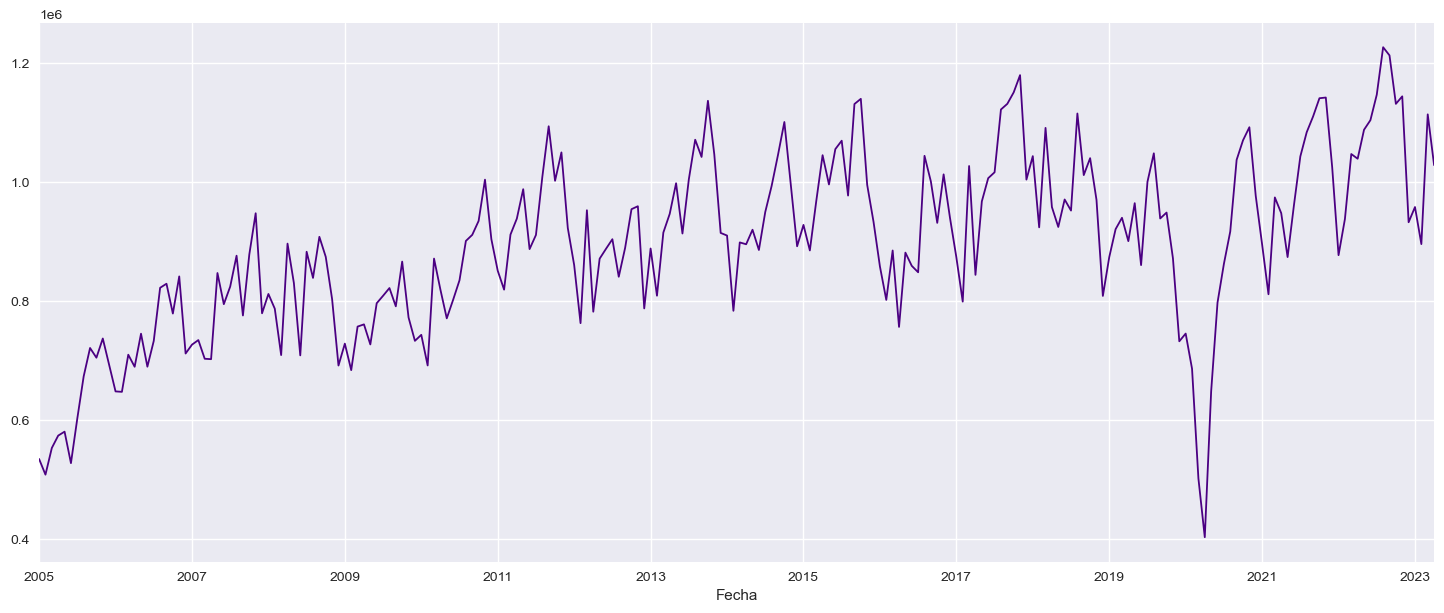

In [19]:
plt.figure(figsize=(18,7))
vble.plot(linewidth=1.3, color ="indigo")
plt.show()

Graficamos los retardos de la serie de tiempo

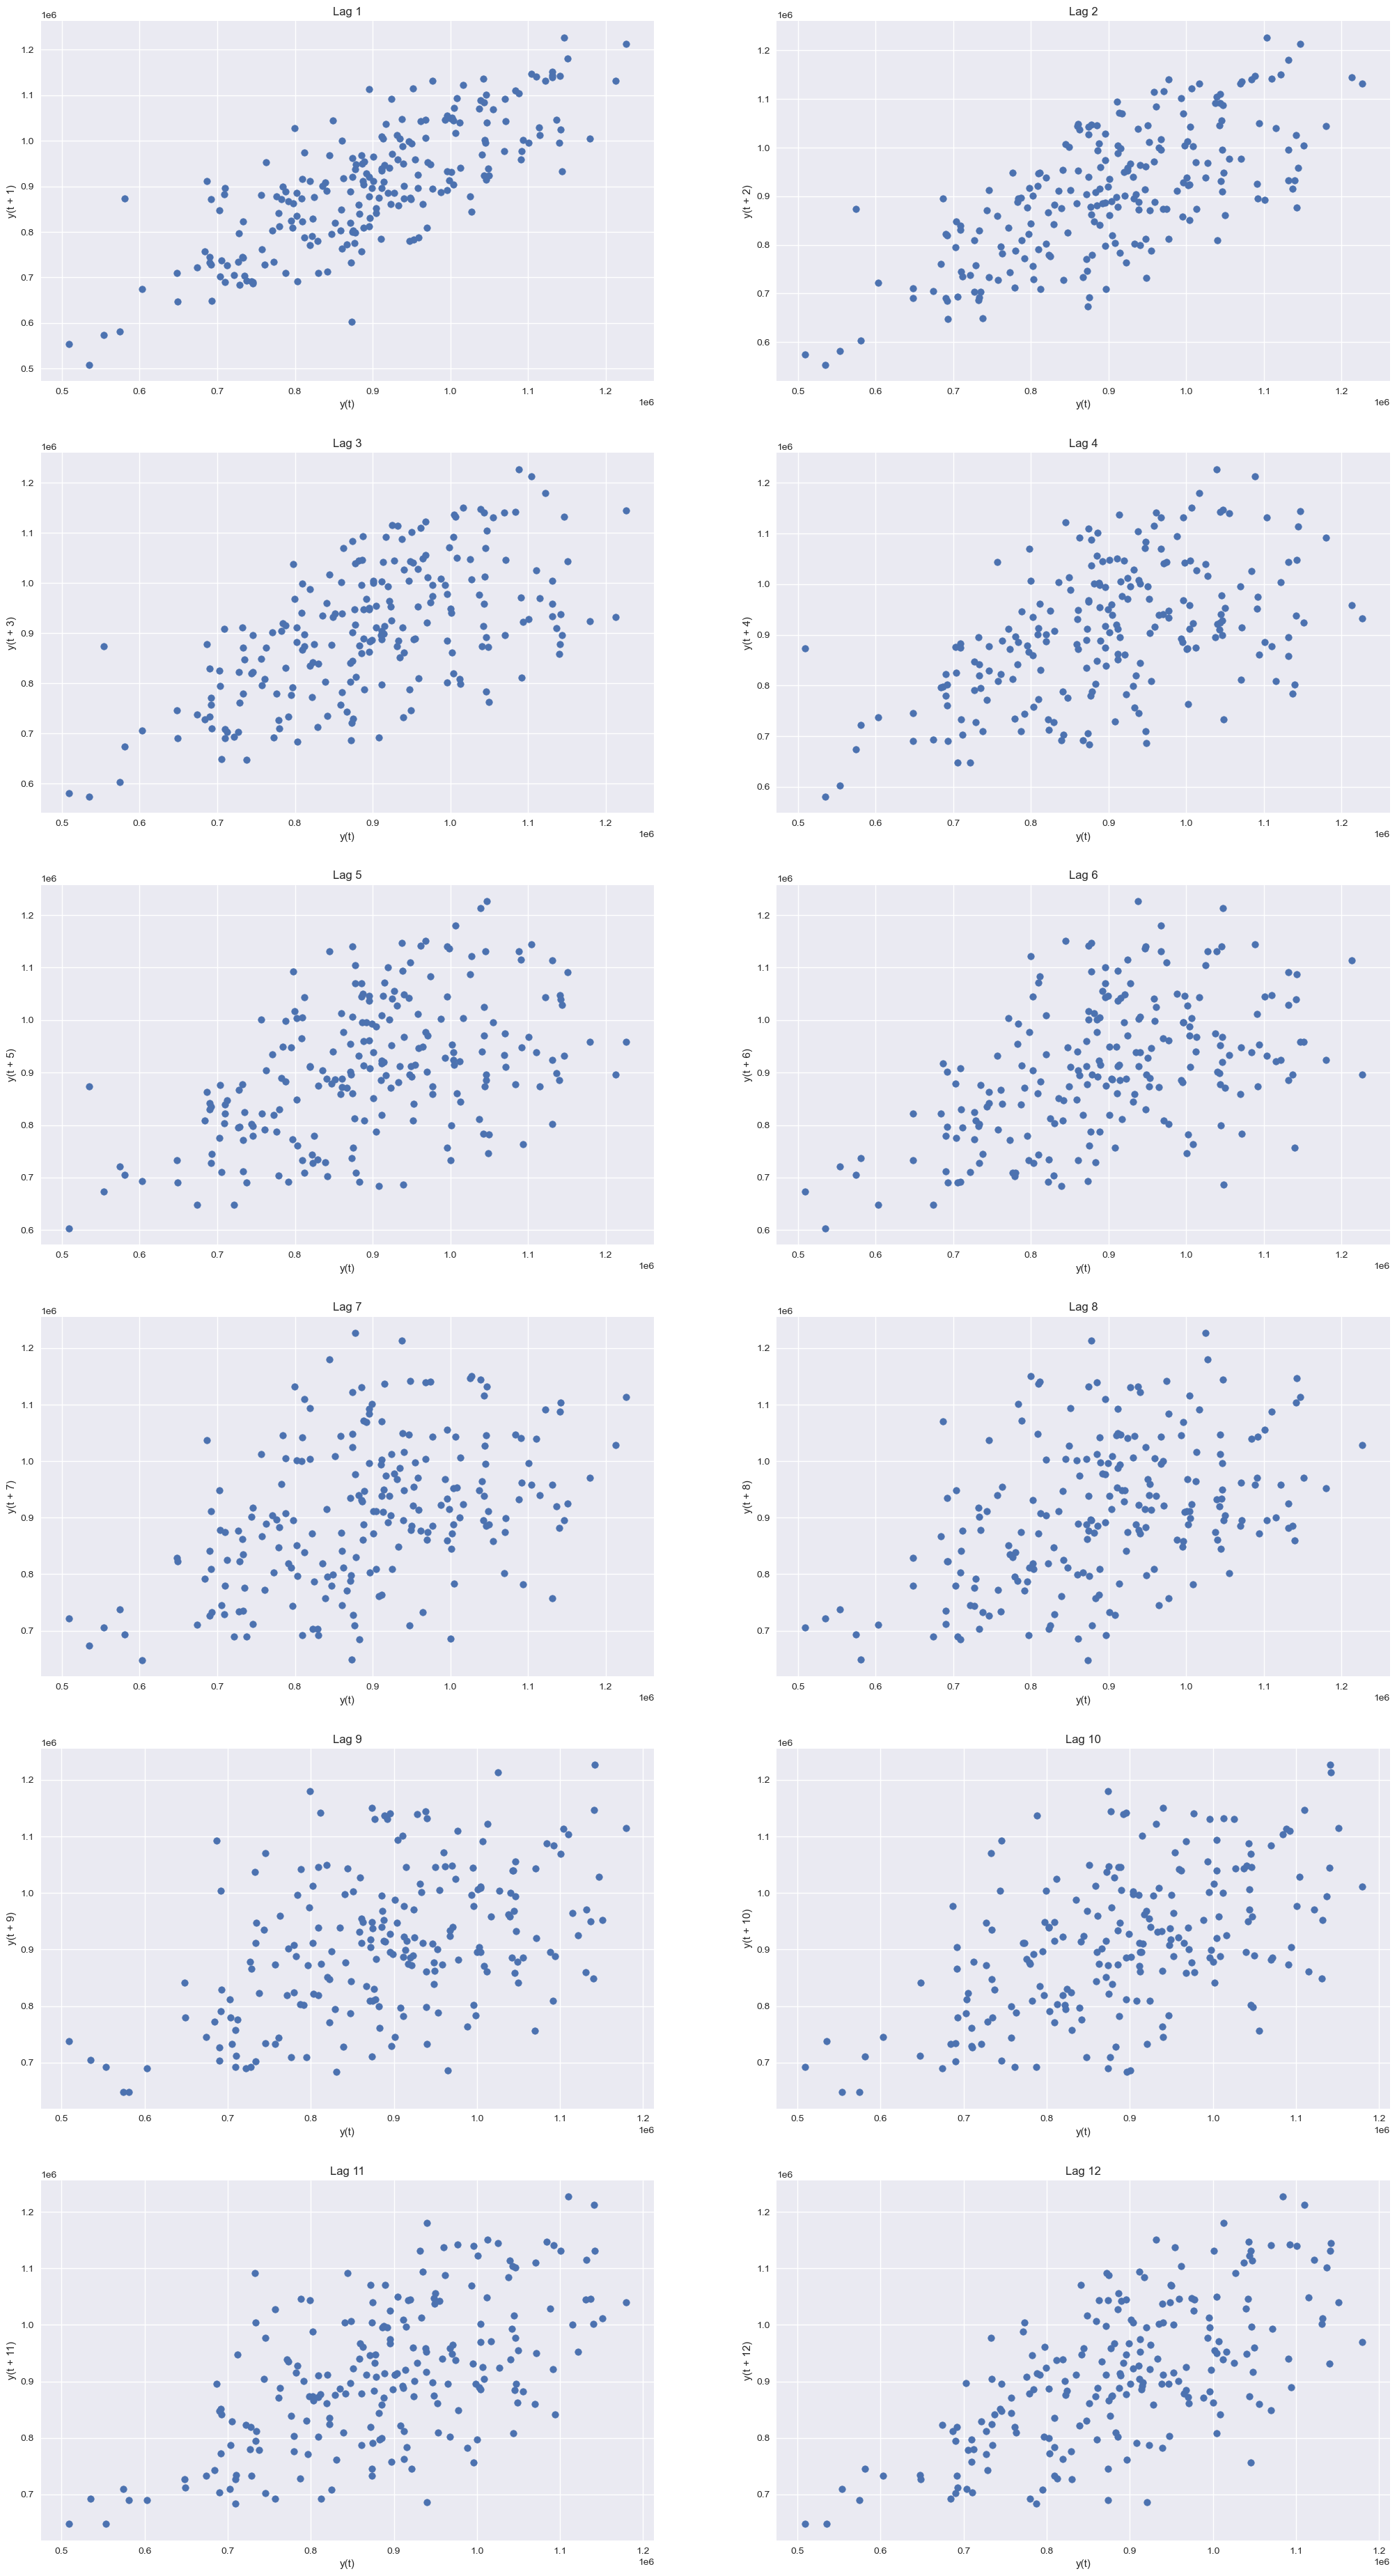

In [20]:
from pandas.plotting import lag_plot
plt.rcParams['figure.figsize'] = [25, 200]
for i in range(12):
    plt.subplot(25,2,i+1)
    plt.title("Lag " + str(i+1))
    lag_plot(df[name],lag=i+1)

>Vemos una ligera tendencia al alza en estos gráfico: los valores bajos tienden a ser seguidos por valores bajos, los valores medianos tienden a ser seguidos por valores medianos y los valores altos tienden a ser seguidos por valores altos.Se refleja una tendencia.
De no verse una tendencia no seria tan relevante de estudiar la serie de tiempo

<a id='descomposicion' />

### 1.1 Descomposición de la serie 

[(back to top)](#contents)


La descomposición de la serie de tiempo lo hace en tendencia, estacionalidad, factores residuales y las observaciones. Para poder trabajar en una proyeccion se debe dejar a los datos libres de estos componentes.

La función "decompose" tiene un parámetro, al que se le debe asignar el valor aditivo o multiplicativo.
1. Modelo aditivo: los datos tienen el mismo ancho y alto que los patrones o picos estacionales. La tendencia de los datos es lineal.
2. Modelo multiplicativo: los datos tienen un ancho y una altura crecientes o decrecientes de los patrones o picos estacionales. La tendencia de los datos no es lineal

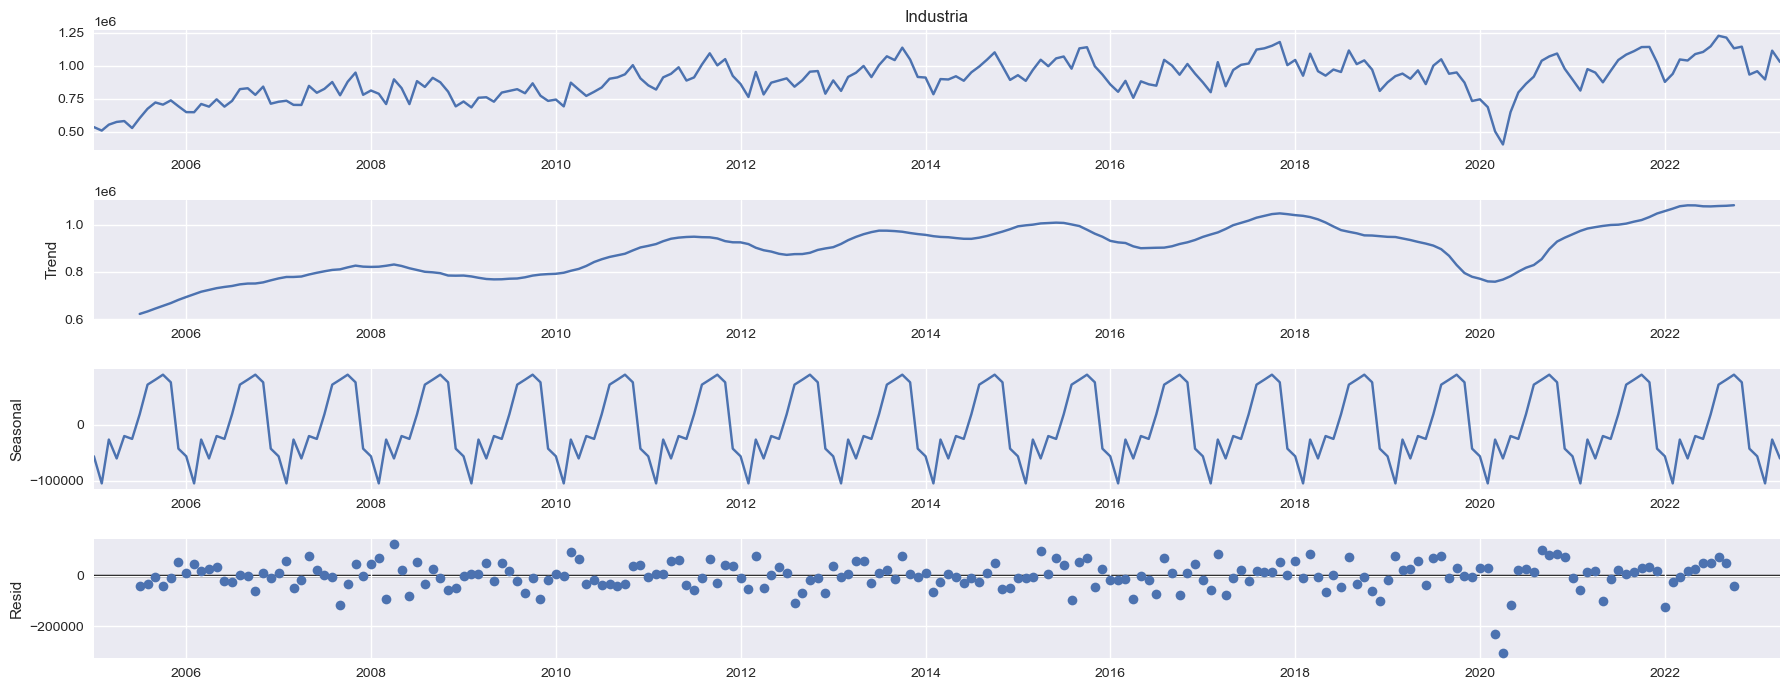

In [21]:
#model: multiplicative o additive
desc = sm.tsa.seasonal_decompose(vble, model ="additive",period= 12) 
plt.rc("figure",figsize=(18,7))
desc.plot()
plt.show()

>Los datos tienen una tendencia alcista no lineal. Si bien, hasta 2014 parece tener una tendencia lineal luego de esta fecha esta curva ascendente se frena y pareciera que se se achata.

>Un claro patrón estacional anual está presente en los datos.

>El último gráfico es el gráfico es el Residuo. Al estar el residuo proximo a uno se muestra como el modelo no ajustar bien. El modelo está subestimando o sobreestimando consistentemente los valores observados en la serie de tiempo.

>Por lo general en estadistica buscamos que los datos no contengan ni tendencia y ni estacionalidad para poder aplicar los modelos.

<a id='identificacion' />

## 2. IDENTIFICACION

[(back to top)](#contents)

<a id='estacionaria' />

### 2.1 ¿Serie Estacionaria o no Estacionaria?


Estacionariedad significa que las propiedades estadísticas de una serie de tiempo, es decir, la media, la varianza y la covarianza, no cambian con el tiempo. 

Cuando la serie es no estacionaria las observaciones muestran efectos estacionales, tendecias y otras estructuras que dependen del tiempo. Los estadisticos de resumen como la media y la varianza cambian con el tiempo, lo que proporciona una desviacion en los conceptos que un modelo puede intentar capturar.


¿Por qué se comprueba esto?

- Muchos modelos estadísticos requieren que la serie sea estacionaria para hacer predicciones efectivas y precisas. Ejemplo de ello son los modelos de regresión lineal, los cuales funcionan mejor cuando los predictores no están correlacionados y son independientes entre sí

<a id='grafico' />

#### 2.2.1 Método Gráfico

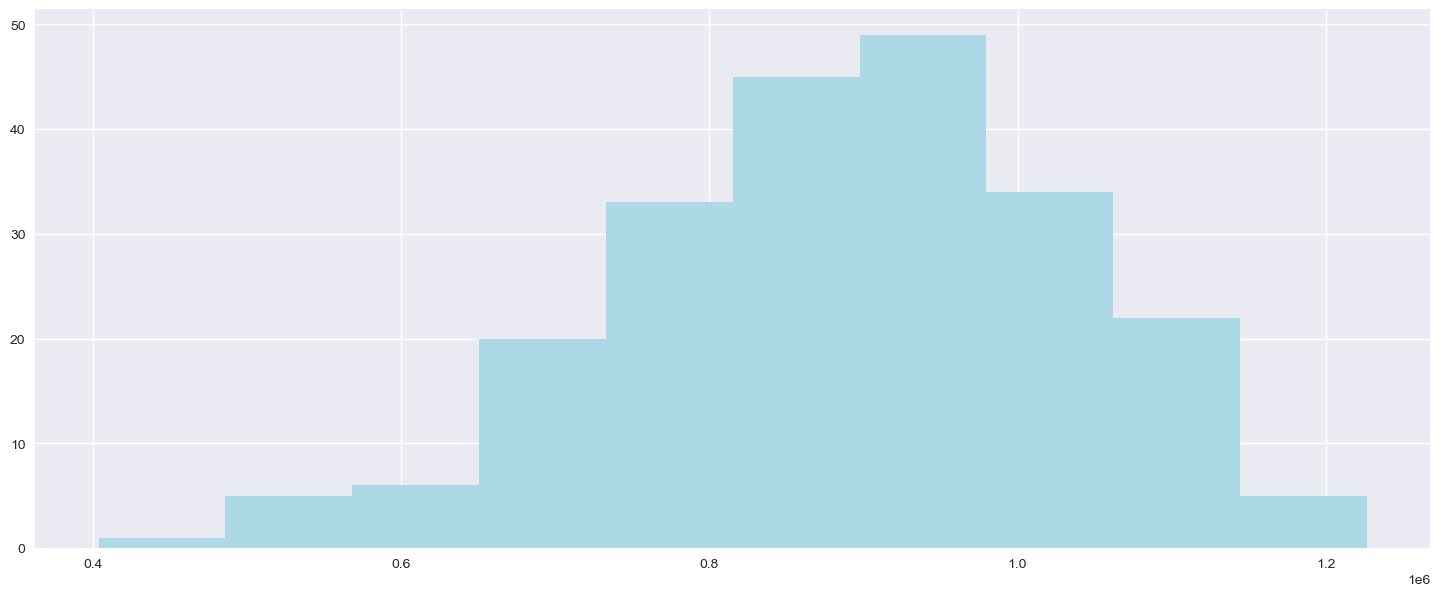

<Figure size 1500x700 with 0 Axes>

In [22]:
vble.hist(color = "lightblue")
plt.figure(figsize=(15,7))
plt.show()

>Vemos que los datos no están centrados.

>En principio parecería ser una serie no estacionaria ya que la distribucion no se parece a una gaussiana. Vemos una asimetria hacia la izquierda

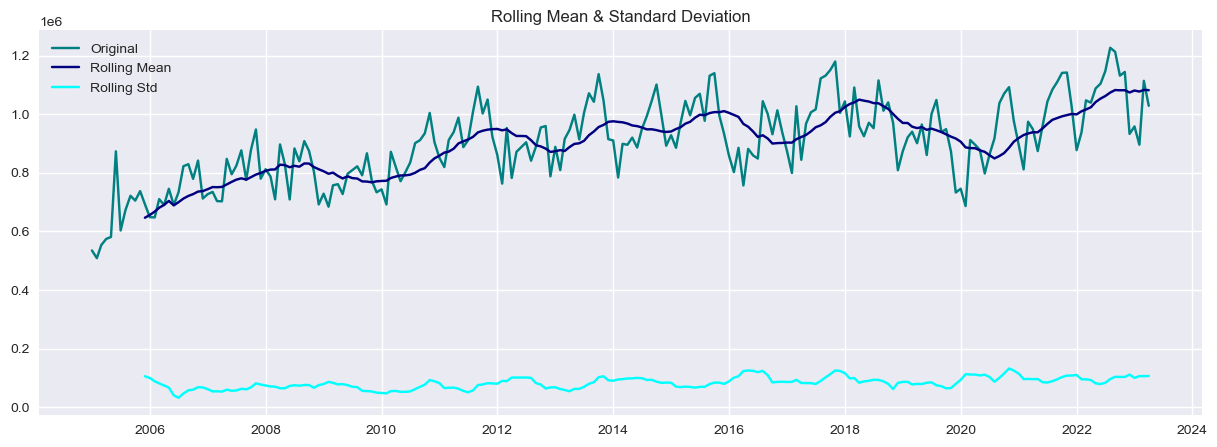

In [23]:
test_stationarity(df[name])

>Vemos que la desviación estándar móvil mantiene cambios con el tiempo (no es una linea recta) por lo que esto nos indicaria que debemos aplica el log para mejorar esta situación.

<a id='formal' />

#### 2.2.2 Contraste Formal


Se utilizan dos pruebas estadísticas para comprobar la estacionariedad de una serie temporal: la prueba de Dickey Fuller aumentada ("ADF") y la prueba de Kwiatkowski-Phillips-Schmidt-Shin ("KPSS"). 

Los resultados obtenidos pueden ser:
- **Caso 1**: Ambas pruebas concluyen que la serie no es estacionaria -> serie no estacionaria
- **Caso 2**: Ambas pruebas concluyen que la serie es estacionaria -> serie estacionaria
- **Caso 3**: KPSS indica estacionariedad y ADF indica no estacionariedad -> serie de tendencia estacionaria.

Es necesario eliminar la tendencia para que la serie sea estrictamente estacionaria. Se puede desvincular por diferenciación o por ajuste de modelo.
- **Caso 4**: KPSS indica no estacionariedad y ADF indica estacionariedad -> serie estacionaria en diferencia.

La diferenciación se utilizará para hacer que las series sean estacionarias. 

<a id='dfa' />

##### 2.2.2.1 Test de Dickey Fuller Aumentado

La prueba ADF es un tipo de prueba de raíz unitaria que indica si la serie es o no estacionaria.
- Ho: γ=0 La serie tiene raíz unitaria es **no estacionaria**.
- H1: γ<0 La serie no tiene raíz unitaria es **estacionaria**

<a id='kpss' />

#####  2.2.2.2 Prueba de  Kwiatkowski-Phillips-Schmidt-Shin ("KPSS")

La prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS) determina si una serie de tiempo es estacionaria alrededor de una tendencia media o lineal , o si no es estacionaria debido a una raíz unitaria.

Al contrario de la mayoría de las pruebas de raíz unitaria, la presencia de una raíz unitaria no es la hipótesis nula sino la alternativa
- Ho: El proceso es de **tendencia estacionaria**.
- H1: La serie tiene una raíz unitaria es **no es estacionaria**.

Los datos normalmente se transforman logarítmicamente antes de ejecutar la prueba KPSS, para convertir cualquier tendencia exponencial en lineal.

Una gran desventaja de la prueba KPSS es que tiene una alta tasa de errores de tipo I (tiende a rechazar la hipótesis nula con demasiada frecuencia).

¿Cuál es la diferencia?
Tanto en los procesos de raíz unitaria como en los de tendencia estacionaria, la media puede crecer o disminuir con el tiempo; sin embargo, en presencia de un shock, los procesos **estacionarios de tendencia son reversibles a la media** (es decir, transitorios, la serie de tiempo convergerá nuevamente hacia la media creciente, que no se vio afectada por el shock) mientras que en los procesos con raíz unitaria el impacto en la media es permanente (es decir, no convergen en el tiempo).


In [24]:
dickey_fuller(vble)
kpss_test(vble)

H0: No estacionaria. Tiene una raiz unitaria
H1: Estacionaria.

Results of Dickey-Fuller Test:
P-value                 0.081
Test Statistic ADF      -2.66
Para el valor crítico de (1%)  -3.46 NO existe evidencia para rechazar HO
Para el valor crítico de (5%)  -2.88 NO existe evidencia para rechazar HO
Para el valor crítico de (10%)  -2.57 existe evidencia para rechazar HO

Como el p-value (0.081) > 0.05 alpha, y es posible que ADF -2.66 > ( 1% y/o 5% y/o 10% ) 
No existe evidencia suficiente para rechaza la Ho.

La series es NO estacionaria, tiene raiz unitaria y se debe transformar.
--------------------------------------------------
H0: Es de tendencia estacionaria.
H1: No estacionaria.

Results of KPSS Test:
P-value                  0.01
Test Statistic KPSS      1.34
Para el valor crítico de (10%)  0.35 existe evidencia para rechazar HO
Para el valor crítico de (5%)  0.46 existe evidencia para rechazar HO
Para el valor crítico de (2.5%)  0.57 existe evidencia para rechazar HO
Para el

C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


> Como vemos que existe solo evidencia para rechazar HO para un nivel del 10% en el ADF y como vimos con anterioridad que la serie se debia transformar al no ser estacionaria, continuamos con el proceso de trasformacion de la serie.

>La representacion gráfica de la serie de tiempo nos proporciona información visual sobre su comportamiento. Se pueden examinar patrones claros, tendencias, estacionalidad y cambios en la variación a lo largo del tiempo. Si la serie de tiempo muestra una tendencia o fluctuaciones significativas, esto indica que no hay estacionariedad.

<a id='transformacion' />

#### 2.2.3 Transformación de la serie


El proceso de no estacionariedad puede ser en varianza o en media.
- Si tienen tendencia es en media por diferencia
- Si es el varianza es por log 

Cualquier operación de transformación aplicada a la serie también requiere que se aplique una transformación inversa similar en las predicciones.

#### Eliminar el efecto estacionalidad
- Transformacion de Diferencia: diferenciación de primer orden (t - (t-12))

Los proximos tres pueden generar coef sesgados sino se divide previamente el set entre entrenamiento y prueba.
#### Eliminar el efecto de heterocedasticidad (cambios en la varianza) a lo largo del tiempo
- Transformacion Logaritmica
- Transformacion de Box-Cox
- Transformacion de Yeo-Johnson

#### Estadarización
- Transformación de datos con distribución gaussiana. Resta la media y divide el resultado por la desviación estándar de la muestra de datos.(Me=0;DS=1)

#### Normalización


Para nuestro caso consideramos la diferenciación. Pierdo una observación

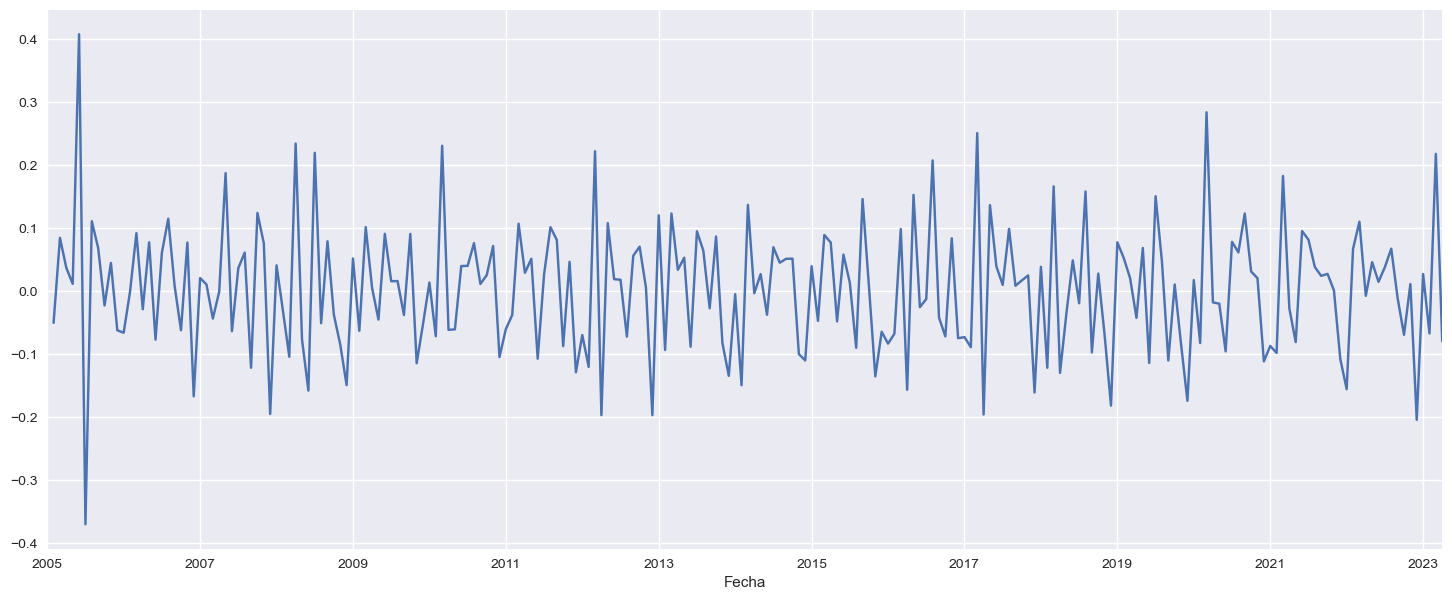

In [25]:
# Utilizar el .diff de pandas .diff (self, períodos = 1, eje = 0) o np.log para el caso de que sea en varianza
#df[f"{name}1"] = vble - vble.shift(1)

df[f"{name}log"] = np.log(df[name])
df[f"{name}1"] = df[f"{name}log"].diff()
df[f"{name}1"] = df[f"{name}1"].dropna()
df[f"{name}1"].plot(figsize=(18,7))
plt.show()

In [26]:
vble_log_diff = df[f"{name}1"]
vble_log_diff 

Fecha
2005-01-01         NaN
2005-02-01   -0.050428
2005-03-01    0.084497
2005-04-01    0.036783
2005-05-01    0.011452
                ...   
2022-12-01   -0.204352
2023-01-01    0.027046
2023-02-01   -0.067217
2023-03-01    0.217760
2023-04-01   -0.079679
Name: Industria1, Length: 220, dtype: float64

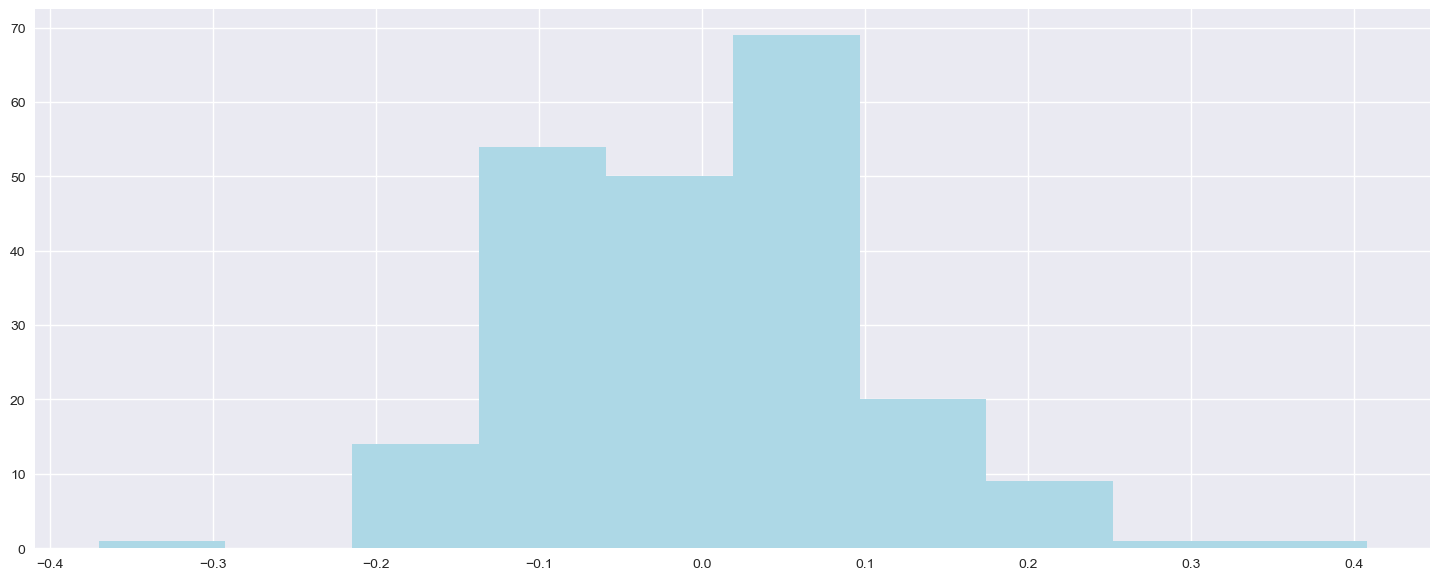

<Figure size 1500x700 with 0 Axes>

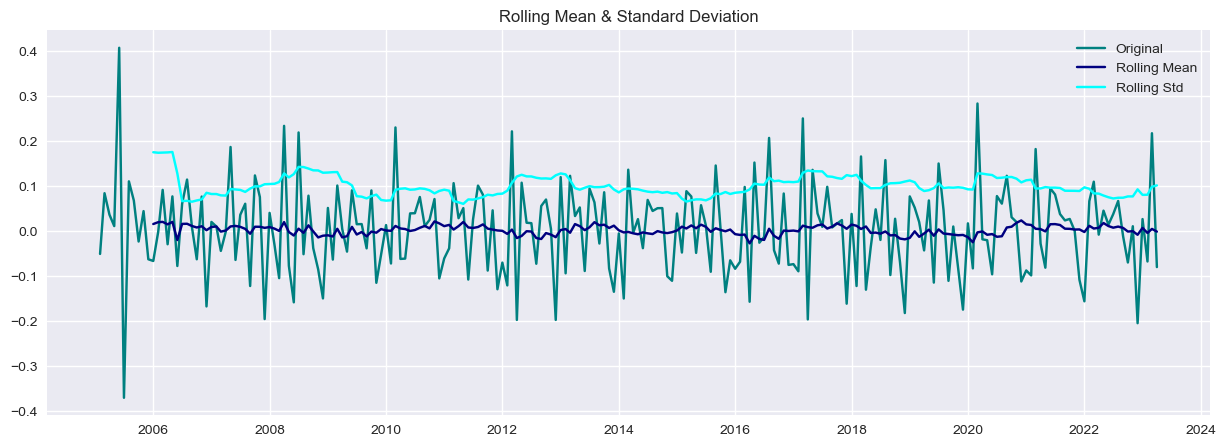

In [27]:
vble_log_diff.hist(color = "lightblue")
plt.figure(figsize=(15,7))
plt.show()
test_stationarity(vble_log_diff)

> Hemos tomado el logaritmo de los datos para tratar con la estacionariedad y la diferenciación se hace para manejar la tendencia y la estacionalidad.
La tendencia y la estacionalidad de los datos casi han disminuido y sus valores también se han reducido.
Ahora comprobamos la estacionariedad de la serie temporal.

Volvemos a calcular los test para ver si fue correcta la trasformación

In [28]:
dickey_fuller(vble_log_diff.dropna())
kpss_test(vble_log_diff.dropna())

H0: No estacionaria. Tiene una raiz unitaria
H1: Estacionaria.

Results of Dickey-Fuller Test:
P-value                 0.001
Test Statistic ADF      -4.08
Para el valor crítico de (1%)  -3.46 existe evidencia para rechazar HO
Para el valor crítico de (5%)  -2.88 existe evidencia para rechazar HO
Para el valor crítico de (10%)  -2.57 existe evidencia para rechazar HO

Como el p-value 0.001 < 0.05 alpha, y es posible que ADF -4.08 < ( 1% y/o 5% y/o 10% )

La series es Estacionaria.
--------------------------------------------------
H0: Es de tendencia estacionaria.
H1: No estacionaria.

Results of KPSS Test:
P-value                  0.1
Test Statistic KPSS      0.08
Para el valor crítico de (10%)  0.35 NO existe evidencia para rechazar HO
Para el valor crítico de (5%)  0.46 NO existe evidencia para rechazar HO
Para el valor crítico de (2.5%)  0.57 NO existe evidencia para rechazar HO
Para el valor crítico de (1%)  0.74 NO existe evidencia para rechazar HO

Como el p-value (0.1) > 0.05 al

C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<a id='estimacion' />

### 3. ESTIMACION - MODELIZACION

[(back to top)](#contents)

Con la serie ya transformada en estacionaria se calcula p,d,q para realizar el modelo ARIMA

<a id='acf' />

#### 3.1 Buscamos el valor de "**p**" y "**q**".

#### Autocorrelación
El gráfico de autocorrelacion ve la parte de MA de la serie, es decir, los errores de pronóstico retrasados. 
- Si la misma cae exponencialmente o parecido a ello no asume un orden el valor de q, es decir, q = 0 no tengo parte de MA. 
- Ahora si tengo un coeficiente que sale por las bandas de confianza veo cual es y ese va a ser mi q.

El ACF muestra la correlacion entre la serie temporal y sus propios valores rezagados. Por ej: ACF en el rezago 7 se calcula como la correlacion entre la serie (Yt) y la misma serie rezagada en 7 periodos de tiempo (Yt-7). Es decir, es un grafico que muestra el coeficiente de correlacion en cada retraso.

#### Autocorrelación Parcial
El gráfico de autocorrelacion parcial ve la parte de AR.
- Si la serie cae exponenciamente o se asemeja a esa caida el p = o y por ende no existe parte AR.
- Ahora si tengo retardos que salen de las bandas de confianza veo cuales son y ese es mi valor de p.

El PACF es un retraso dado, es el coeficiente de ese retraso obtenido de la regresion lineal. La regresion incluye todos los retrasos entre el periodo de tiempo actual y el retraso dado como varibales independientes. Es decir, el grafico se construye trazando todos los valores de PACF obtenidos regresiones en diferentes retrasos.

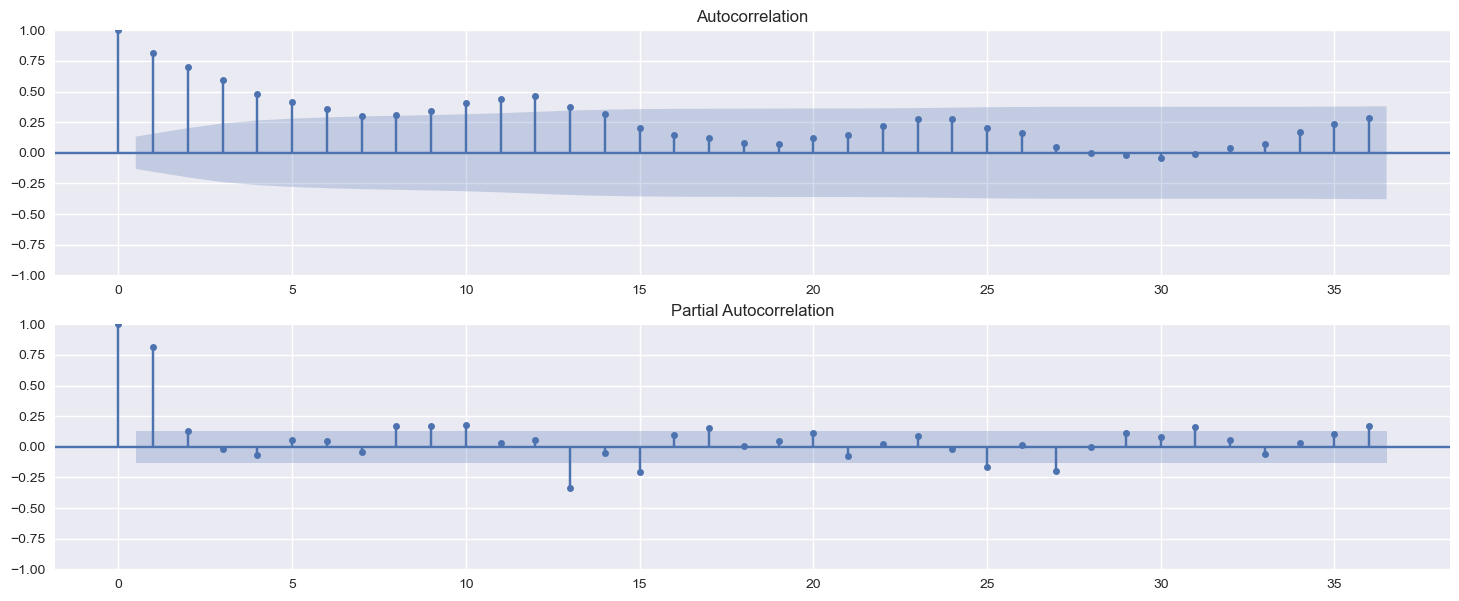

In [29]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(vble.dropna().values.squeeze(), lags=36, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(vble.dropna().values.squeeze(), lags=36, ax=ax2)

> Del gráfico PACF anterior, el primer retraso está fuera del intervalo de confianza y probablemente sea el retraso más
significativo. Probablemente dicta el patrón para el gráfico ACF donde el siguiente retraso sigue al retraso anterior.

> En el grafico ACF se deja ver una estacionalidad cada 12 periodos

#### Con la funcion ya transformada
vble_log_diff

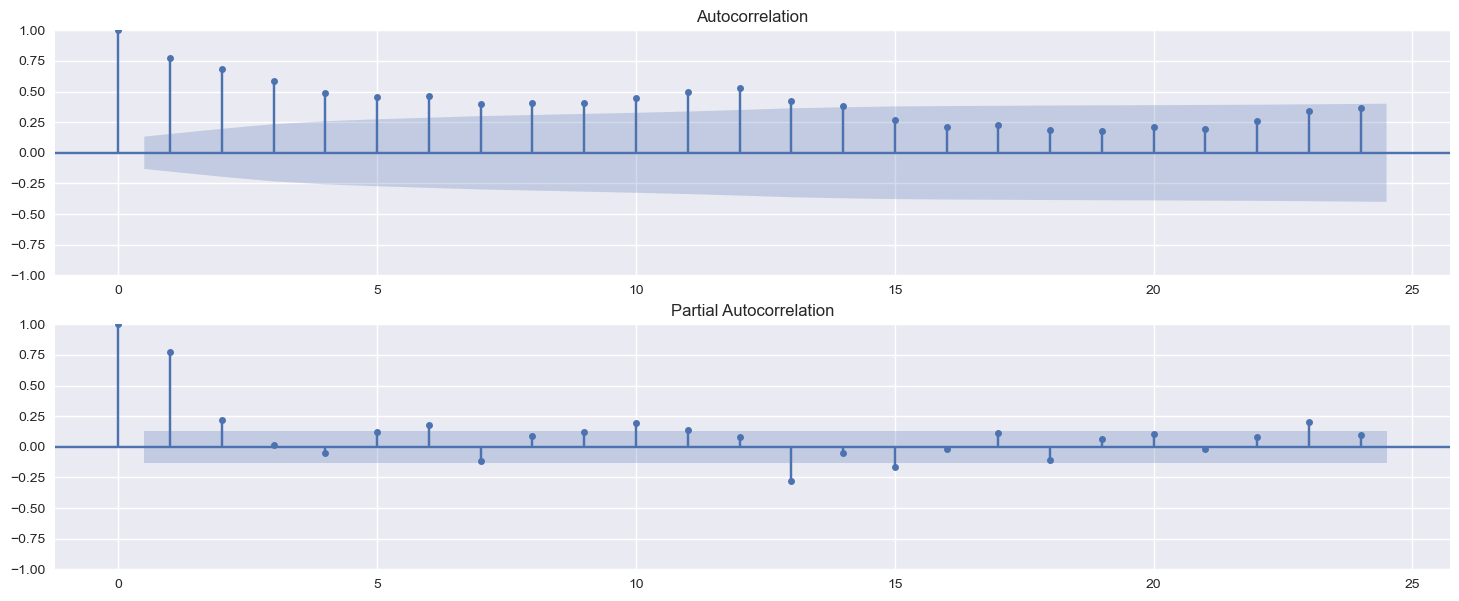

In [30]:
fig = plt.figure(figsize=(18,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df[f"{name}log"].dropna().values.squeeze(), lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df[f"{name}log"].dropna().values.squeeze(), lags=24, ax=ax2)

> En nuesto caso: 

>p : Valor de retraso en el gráfico de autocorrelación parcial (PACF) que queda por fuera del intervalo de confianza. Contamos la cantidad de lineas que se encuentran por encima/debajo del intervalo de confianza antes de que la siguiente ingrese al área azul. 

>d : Número de veces que se realiza la diferenciación para hacer estacionaria la serie temporal. 

>q : Valor de retraso donde el gráfico de Autocorrelación (ACF) cruza el intervalo de confianza superior para la primera instancia. Contamos la cantidad de lineas que se encuentran por encima/debajo del intervalo de confianza antes de que la siguiente ingrese al área azul.

Q es dificil de identificar

In [59]:
p = 1
d = 1
q = 1 

<a id='modelo' />

#### 3.2  Modelo

C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MSE: 0.010
MAE: 0.05
R2: 0.46


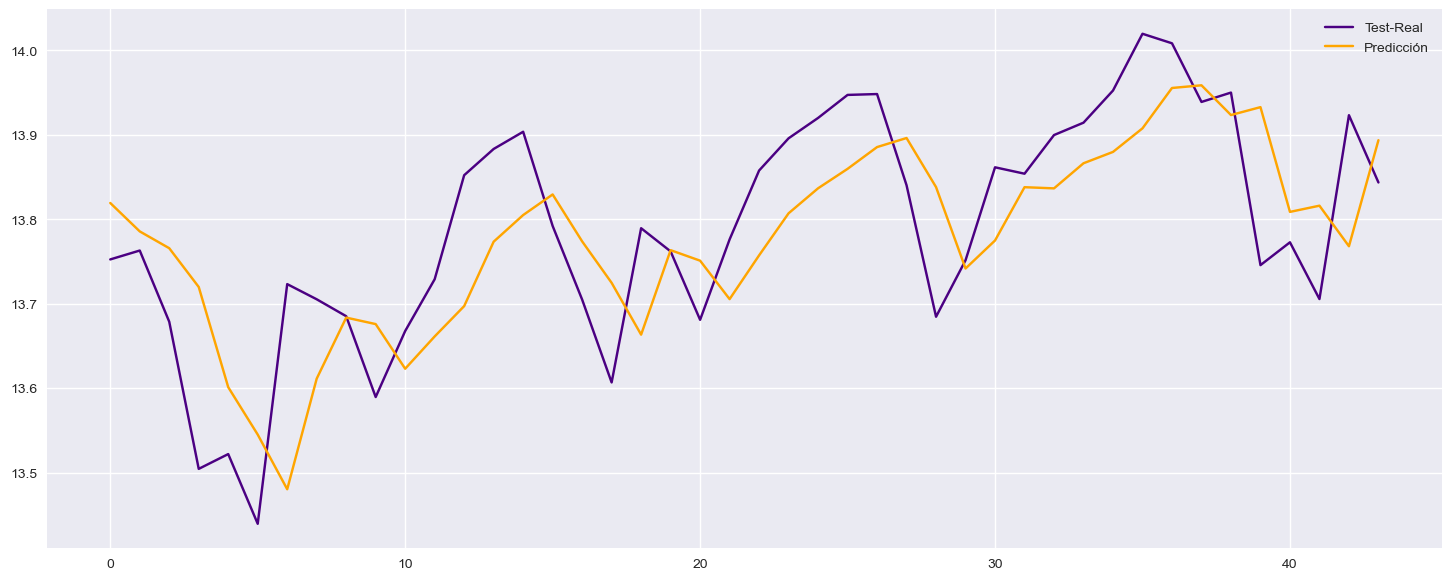

,real,pronóstico,residuos
39,13.745797,13.932910,-0.187113
40,13.772843,13.808855,-0.036012
41,13.705626,13.816200,-0.110573
42,13.923386,13.768172,0.155214
43,13.843707,13.893752,-0.050045


In [60]:
modelo = modelo_arima(df[f"{name}log"], p, d, q)
modelo.tail()

<a id='diagnostico' />

### 4. DIAGNOSTICO DEL MODELO

[(back to top)](#contents)

<a id='residuos' />

#### 4.1 Residuos

#### Diagnóstico de los residuos
- Standardized residual (gráfica superior izquierda): muestra los residuos a lo largo del tiempo. Los mismos no debe mostrar ningun patron claro de estacionalidad y deben parecer un ruido blanco.  
- Histogram plus estimated density (la gráfica superior derecha): se debe ver que la linea KDE sigue de cerca a la linea normal N(0,1) donde la misma simboliza la notación estándar para una distribución normal con media cero y desviación estándar uno. Ésta es una buena indicación de que los residuos se distribuyen normalmente.
- El gráfico QQ en la parte inferior izquierda muestra que la distribución ordenada de los residuos (puntos azules) sigue la tendencia lineal de las muestras tomadas de una distribución normal estándar con N(0, 1). Nuevamente, esta es una fuerte indicación de que los residuos se distribuyen normalmente.
- La gráfica de autocorrelación (es decir, correlograma) en la parte inferior derecha, que muestra que los residuos de la serie de tiempo tienen baja correlación con versiones rezagadas de sí mismo.


Si estas observaciones son correctas es posible concluir que nuestro modelo produce un ajuste satisfactorio que podría ayudarnos a comprender nuestros datos de series de tiempo y pronosticar valores futuros.

C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


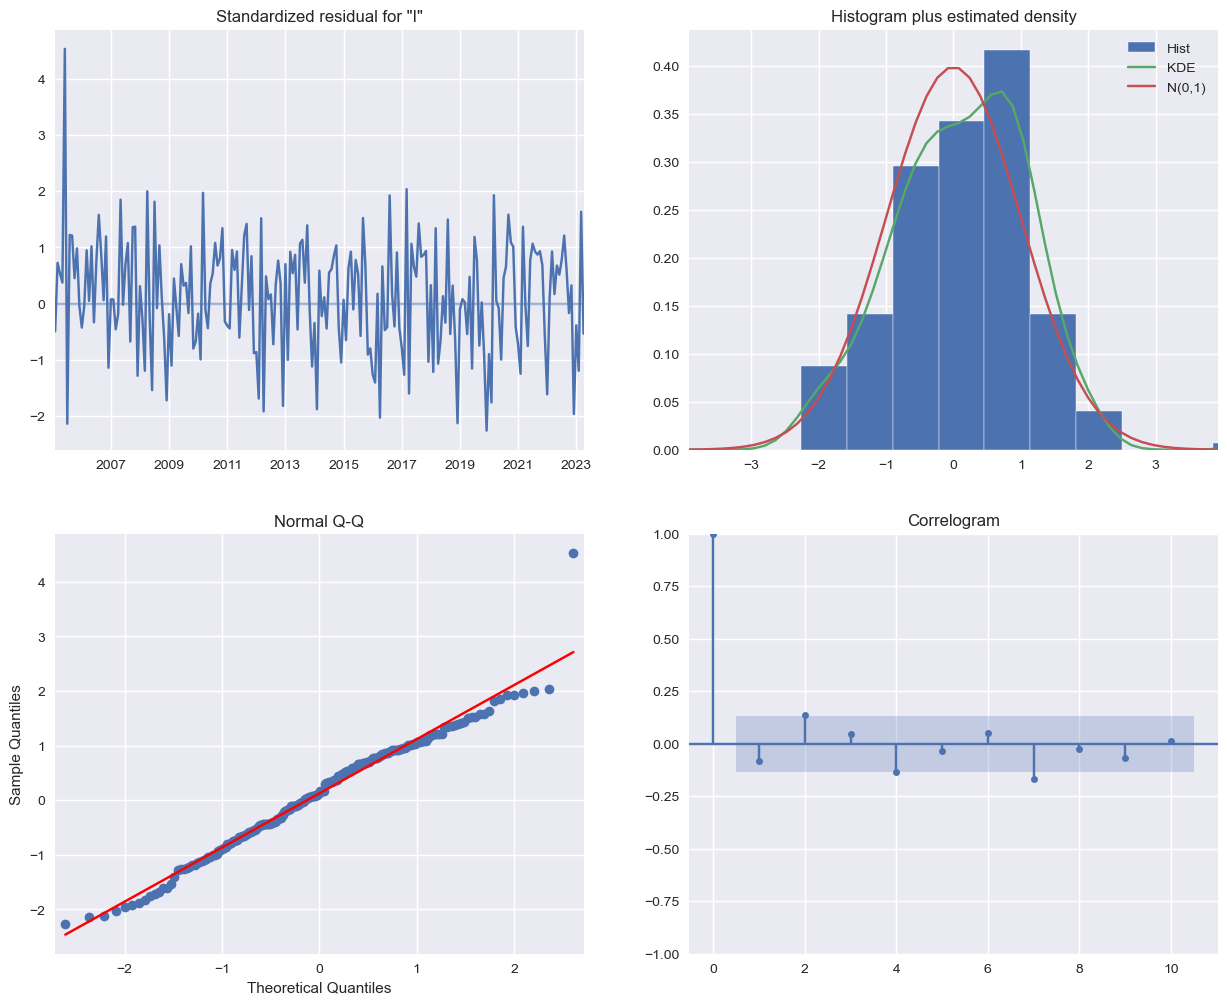

None


In [61]:
print(residuos(df[f"{name}log"], p,d,q, False))

> Histogram plus estimated density: se aleja un poco de la curva normal que deberia acompañar

> Normal QQ:

> Correlogram: se ven todos dentro de la rectangulo azul

> Por tanto, esto nos hace concluir que nuestro modelo se ajusta bastante bien y podría ser usado para predecir valores futuros, a priori.

<a id='resumida' />

### 5. ESTADISTICA RESUMIDA

[(back to top)](#contents)

**Log Likelihood**

   Un valor **más alto** del "Log Likelihood" indica que el modelo se ajusta mejor a los datos observados.

**Criterio de información de Akaike (AIC)**

   Dado un conjunto de modelos candidatos para los datos, el modelo preferido es el que tiene el **valor mínimo en el AIC** .  AIC  recompensa la bondad de ajuste, también incluye una penalidad, que es una función creciente del número de parámetros estimados. Esta penalización desalienta el sobreajuste.
    Un AIC más bajo significa que se considera que un modelo está más cerca de la verdad. 
    

**Criterio de información Bayesiano (BIC)**
   
   BIC es una estimación de una función de la probabilidad posterior de que un modelo sea verdadero, bajo una determinada configuración bayesiana, de modo que un **BIC más bajo** significa que se considera que es más probable que un modelo sea el modelo verdadero.

- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory model

**Criterio de informacion de Hannan-Quinn (HQIC)**

   En general, se prefiere un modelo que tenga un valor de **HQIC más bajo**, ya que indica que el modelo ajusta los datos de manera adecuada mientras mantiene un número menor de parámetros, lo que puede ayudar a evitar el sobreajuste.HQIC utiliza una penalización adicional logarítmica al modelo de AIC



**P>|z|**:
1. Muestra el nivel de significancia del peso de cada variable. Si la variable tiene un p-valor menor o igual a 0.05 es razonable mantenerla en el modelo.

**Ljung-Box (o prueba Q)**:  
1. HO.Los residuos se distribuyen de forma independiente. Son un ruido blanco
2. H1.Los residuos no se distribuyen de forma independiente; exhiben correlación serial.(AUTOCORRELACION)

Esta estadística Q sigue una distribución Chi-cuadrado con ℎ grados de libertad bajo la hipótesis nula.
Si el valor calculado del estadistico Q es mayor que el valor crítico de la distribución Chi-cuadrado para un nivel de significancia dado, entonces rechazamos la hipótesis nula y concluimos que hay autocorrelación significativa en los residuos.

**Heteroskedasticity** :
1. H0. Homocedasticidad (varianza constante)
2. H1. Heterocedasticidad 

**Test JarqueBera**:
Detecta la normalidad en los residuos.
1. H0. Simetría y Curtosis exacta. Es normal
2. H1. Existe curtosis o asimetria. Falla la normalidad 

**Skew**

Indica el grado de asimetría en la distribución de los datos. La asimetría es una medida de la falta de simetría en una distribución. Un valor de asimetría cercano a cero sugiere que la distribución es aproximadamente simétrica, es decir, tiene una forma similar a una campana simétrica.
Un valor positivo de "Skew" indica que la distribución tiene una asimetría positiva, lo que significa que la cola derecha de la distribución es más larga o pesada, y la mayoría de los datos se encuentran hacia la izquierda. Un valor negativo de "Skew" indica una asimetría negativa, con una cola izquierda más larga o pesada, y la mayoría de los datos se encuentran hacia la derecha.

**Kurtosis**

La curtosis mide qué tan puntiaguda o achatada es la distribución en comparación con la distribución normal. Un valor de kurtosis igual a 3 correspondería a la curtosis de una distribución normal.

-Si "Kurtosis" es mayor que 3, la distribución se considera leptocúrtica (más puntiaguda que la normal), lo que significa que tiene colas más pesadas y picos más altos que la distribución normal.

-Si "Kurtosis" es menor que 3, la distribución se considera platicúrtica (más achatada que la normal), lo que significa que tiene colas más livianas y picos más bajos que la distribución normal.

In [62]:
print(residuos(df[f"{name}log"],p,d,q, True))

                               SARIMAX Results                                
Dep. Variable:           Industrialog   No. Observations:                  220
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 208.515
Date:                Tue, 25 Jul 2023   AIC                           -411.030
Time:                        18:28:50   BIC                           -400.863
Sample:                    01-01-2005   HQIC                          -406.924
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4743      0.077      6.131      0.000       0.323       0.626
ma.L1         -0.8731      0.050    -17.514      0.000      -0.971      -0.775
sigma2         0.0087      0.001     12.377      0.0

C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\WinUser\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


> **P>|z|**: No tenemos retardos por fuera del criterio.

> **Ljung-Box**: Como el valor de "Prob(Q)" es 0.22, que es mayor que el nivel de significancia 0.05, no hay suficiente evidencia para rechazar la hipótesis nula de no autocorrelación en el primer retraso. Por lo tanto, podemos considerar que los residuos del modelo se comportan como ruido blanco hasta el primer retraso, y el modelo ajusta adecuadamente los datos en términos de autocorrelación hasta ese punto.

> **Heteroskedasticity**: Dado que el p-valor es 0.61, es mayor que el nivel de significancia 0.05. Esto sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de homocedasticidad. En otras palabras, no hay suficiente evidencia para afirmar que hay heteroscedasticidad significativa en los residuos del modelo.

> **Test Skewness-Kurtosis-JarqueBera**:Dado que el p-valor es 0.02, es menor que el nivel de significancia comúnmente utilizado (como 0.05 o 0.01). Esto indica que hay suficiente evidencia para rechazar la hipótesis nula de que los residuos siguen una distribución normal.

> **Skew**: indica una ligera asimetría positiva en la distribución de los datos.
 
> **Kurtosis**: 3.88, lo que sugiere una distribución que es ligeramente leptocúrtica, con colas un poco más pesadas y un pico un poco más alto que la distribución normal.

Se debe trabajar sobre el punto de normalidad.